In [ ]:
# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7  # max number of rows to display

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

# For high resolution display
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [ ]:
def rangeplot(df, x, y, color=None):
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dots(pointsize=8, marker="<"), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )


def boxplot(df, x, y, color=None, alpha=0.1):
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Dots(alpha=alpha, color=".6"), so.Jitter(), so.Dodge())
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dots(pointsize=8, marker="<"), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )

# diamonds 데이터셋 불러오기

In [ ]:
diamonds = sm.datasets.get_rdataset("diamonds", "ggplot2").data

## 특정 컬럼 categorical type로 변형하기

In [ ]:
# cut, color, clarity 모두 categorical type으로 변형
diamonds["cut"] = pd.Categorical(
    diamonds["cut"],
    categories=["Fair", "Good", "Very Good", "Premium", "Ideal"],
    ordered=True
)

# color는 D가 좋은 컬러임, J가 제일 안 좋은 컬러임.
diamonds["color"] = pd.Categorical(
    diamonds["color"],
    categories=["D", "E", "F", "G", "H", "I", "J"],
    ordered=True
)
diamonds["clarity"] = pd.Categorical(
    diamonds["clarity"],
    categories=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
    ordered=True
)

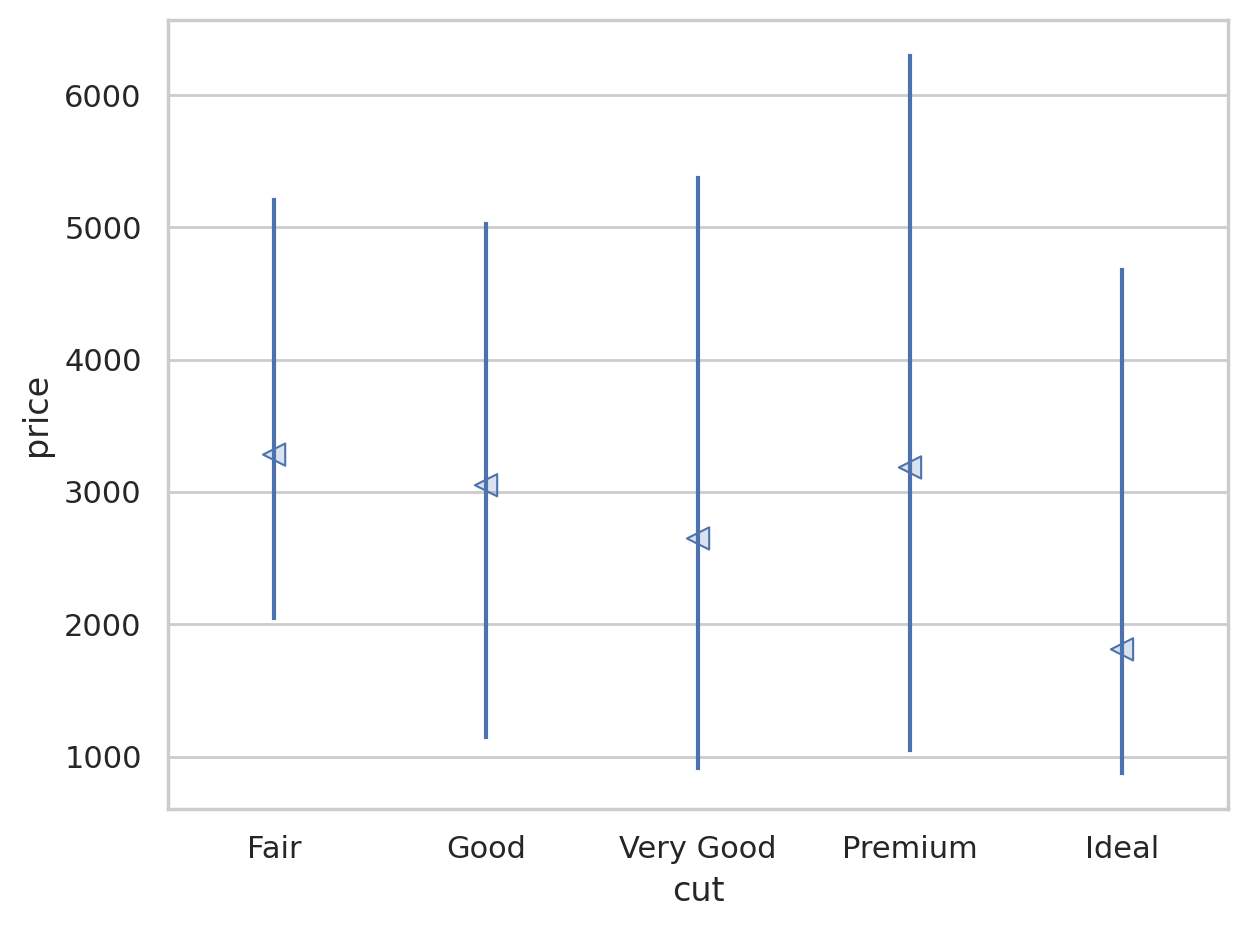

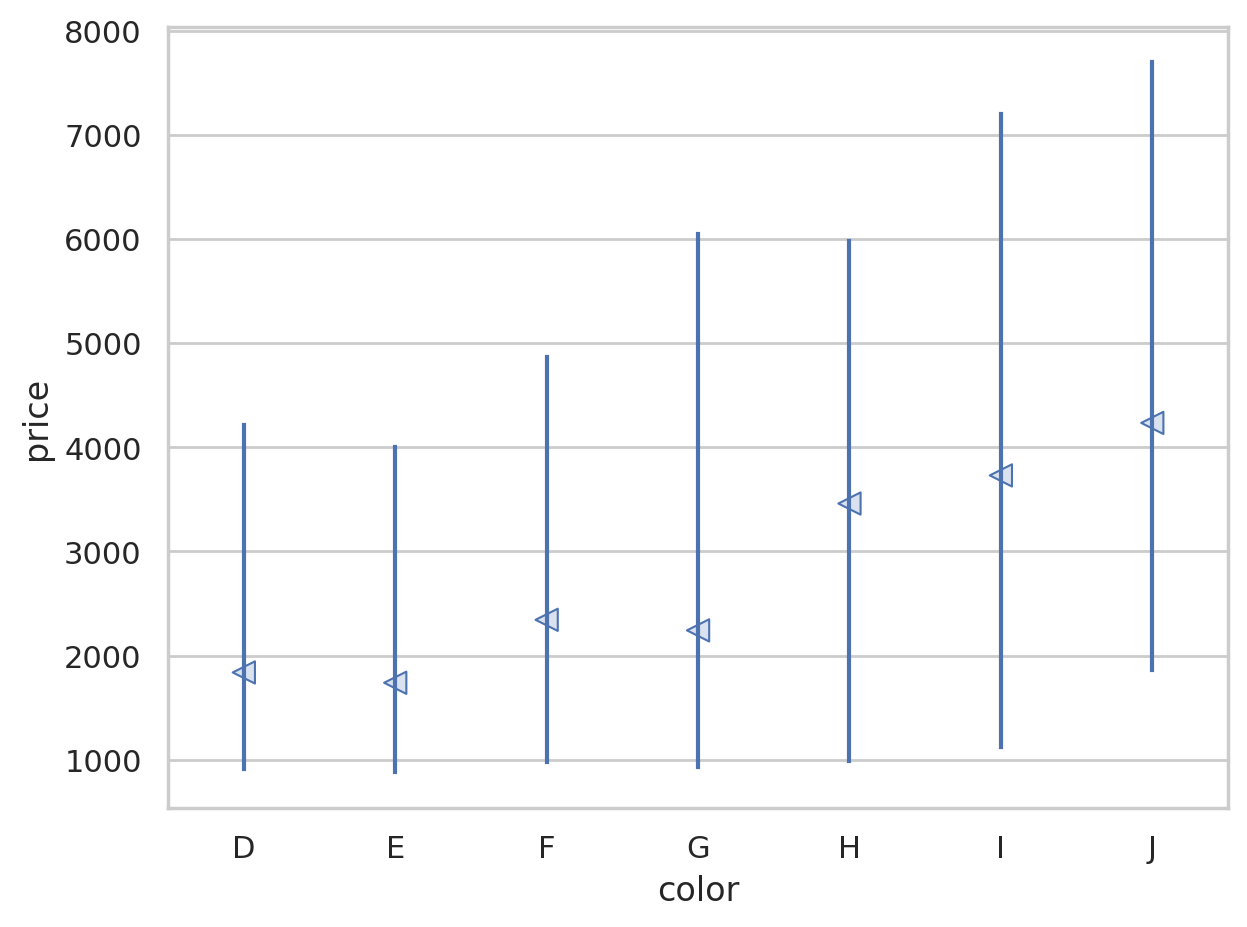

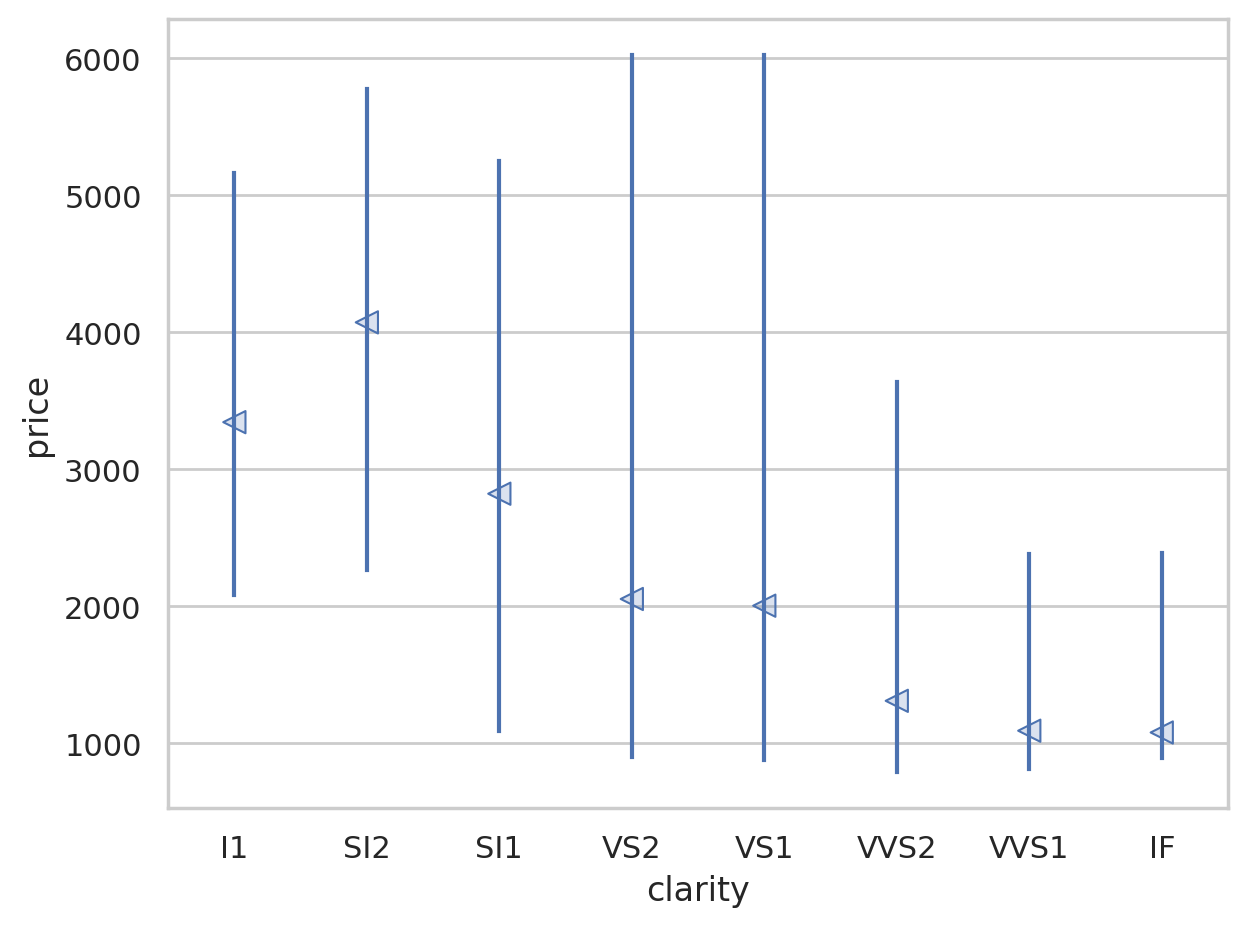

In [ ]:
cut = rangeplot(diamonds, x="cut", y="price").show()
color = rangeplot(diamonds, x="color", y="price").show()
clarity = rangeplot(diamonds, x="clarity", y="price").show()

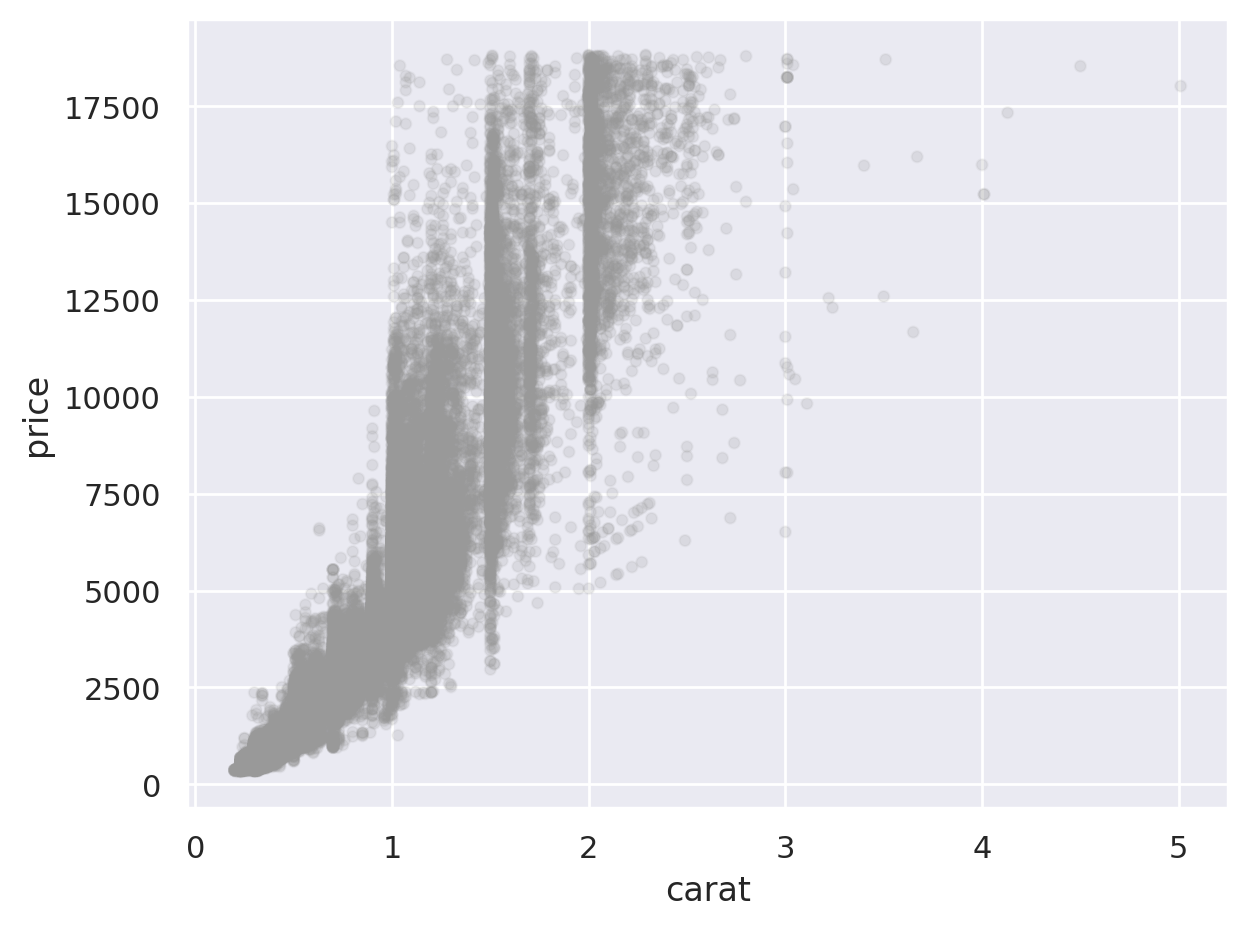

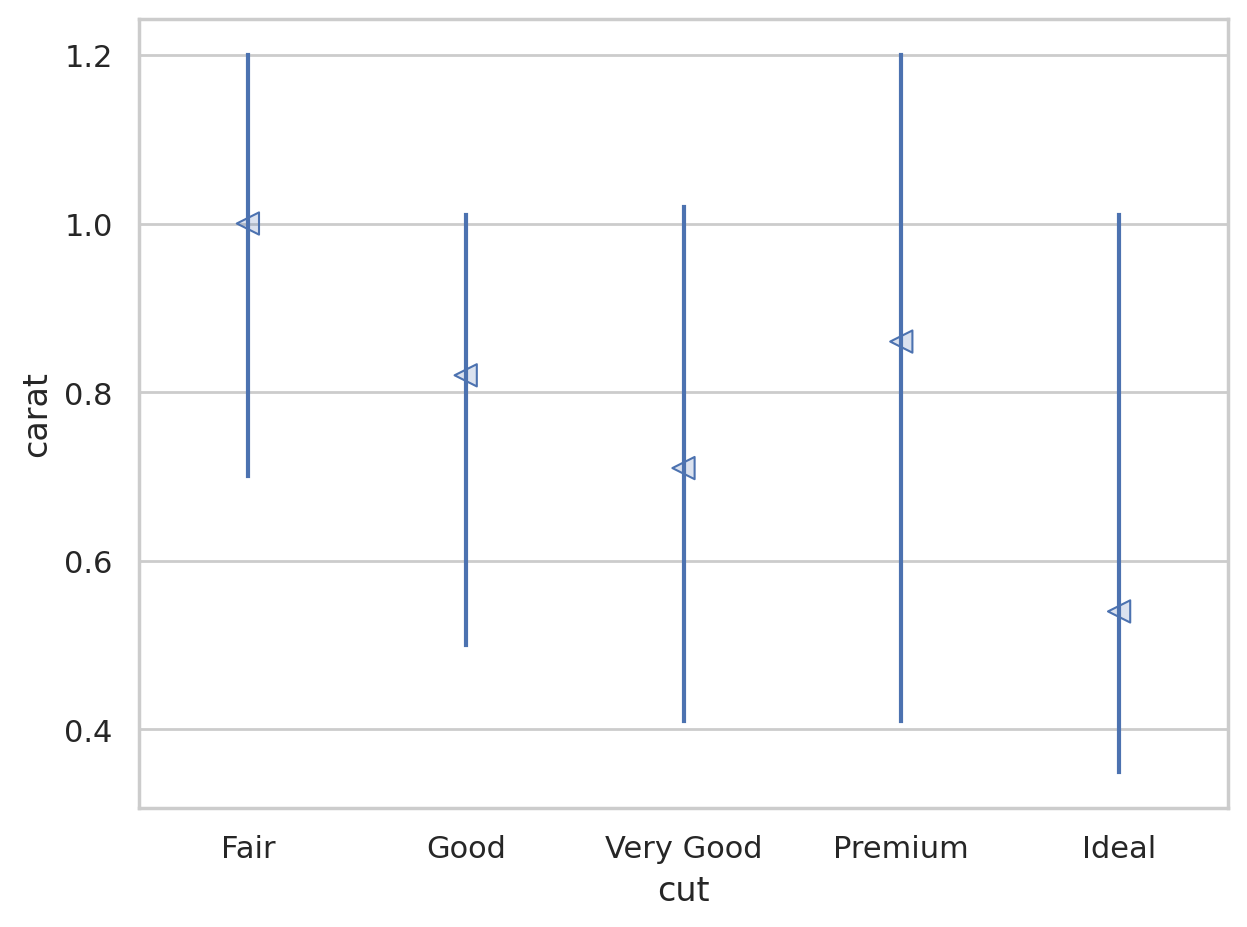

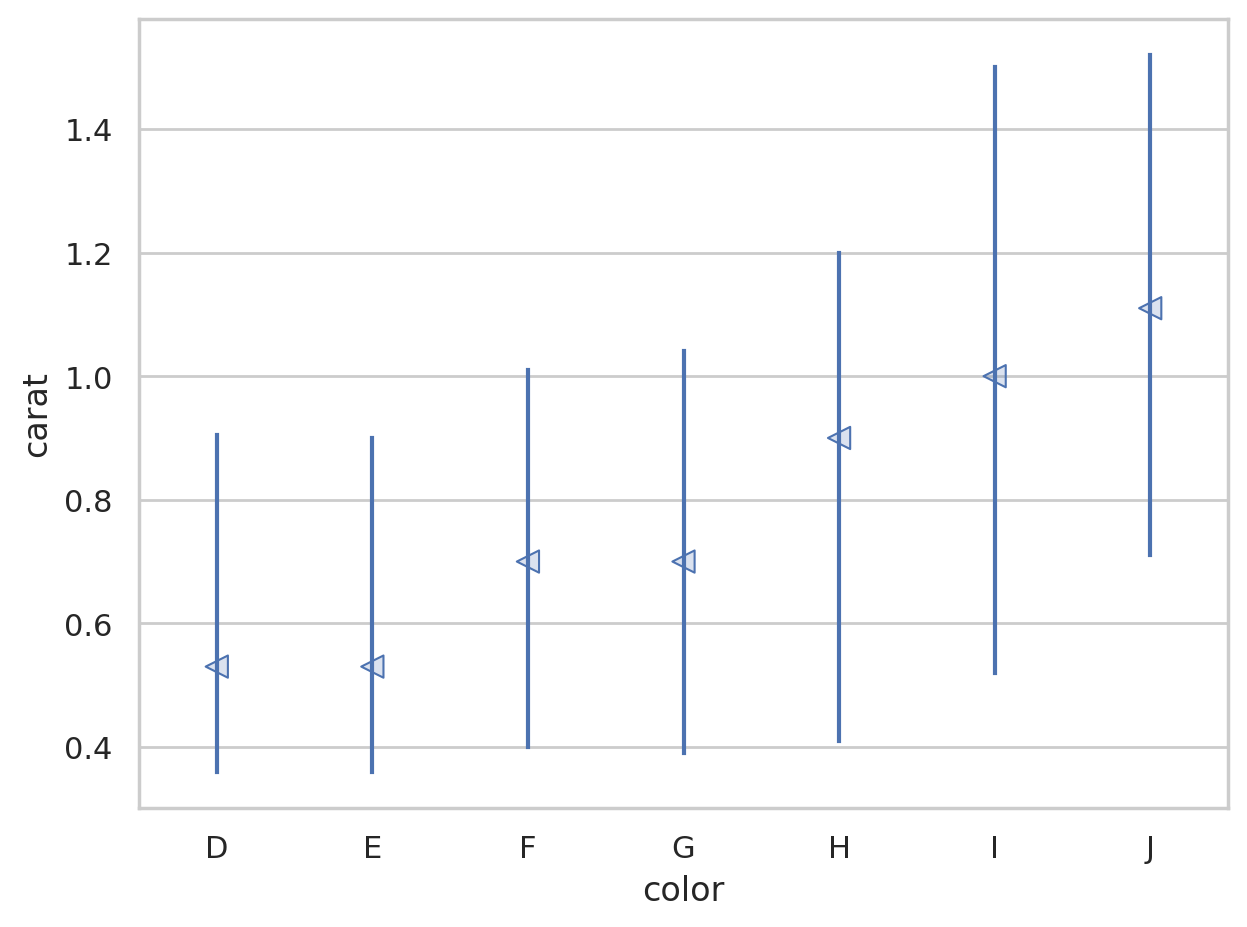

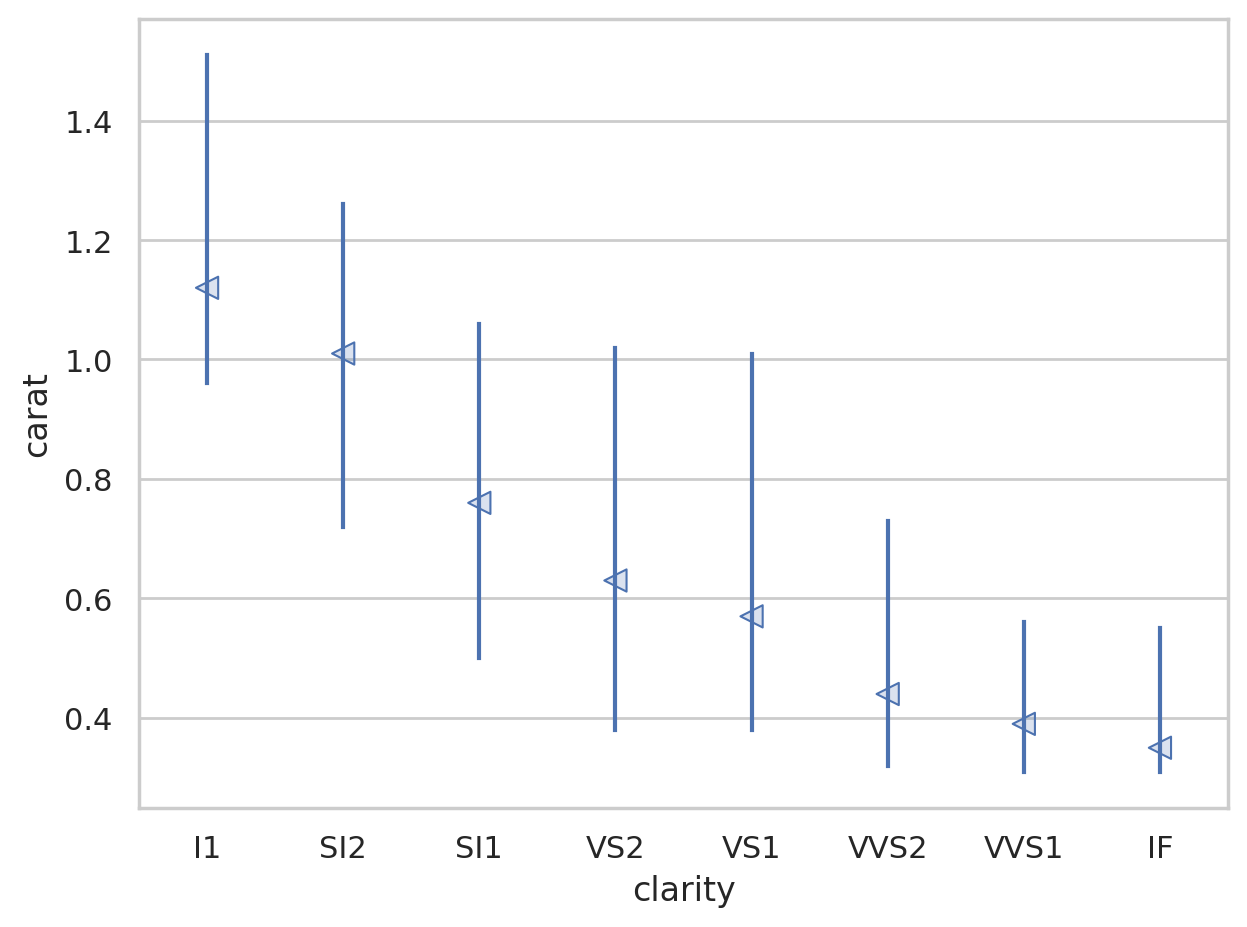

In [ ]:
price = (
    so.Plot(diamonds, x='carat', y='price')
    .add(so.Dots(alpha=.1, color=".6"))
).show()

cut = rangeplot(diamonds, x="cut", y="carat").show()
color = rangeplot(diamonds, x="color", y="carat").show()
clarity = rangeplot(diamonds, x="clarity", y="carat").show()

# 다이아몬드의 퀄리티(cut, color, clarity)가 좋을수록 가벼워짐
# 좋은 거일수록 크기, 무게가 작아진다. 이게 가격 하락을 보임.

## 로그 취하기
### 우선, 2.5캐럿 이하로 제한하고,
### 가격과 캐럿을 log-transform하여 선형모형을 세움
### 이 모형으로 잔차를 구하고,
### 다이아몬드의 퀄리티와 이 잔차와의 관계를 살펴봄

In [ ]:
diamonds2 = diamonds.query("carat < 2.5").assign(
    lprice=lambda x: np.log2(x.price),
    lcarat=lambda x: np.log2(x.carat)
)

diamonds2

,carat,cut,color,clarity,depth,table,price,x,y,z,lprice,lcarat
0,0.23,Ideal,E,SI2,61.50,55.00,326,3.95,3.98,2.43,8.35,-2.12
1,0.21,Premium,E,SI1,59.80,61.00,326,3.89,3.84,2.31,8.35,-2.25
2,0.23,Good,E,VS1,56.90,65.00,327,4.05,4.07,2.31,8.35,-2.12
...,...,...,...,...,...,...,...,...,...,...,...,...
53937,0.70,Very Good,D,SI1,62.80,60.00,2757,5.66,5.68,3.56,11.43,-0.51
53938,0.86,Premium,H,SI2,61.00,58.00,2757,6.15,6.12,3.74,11.43,-0.22
53939,0.75,Ideal,D,SI2,62.20,55.00,2757,5.83,5.87,3.64,11.43,-0.42


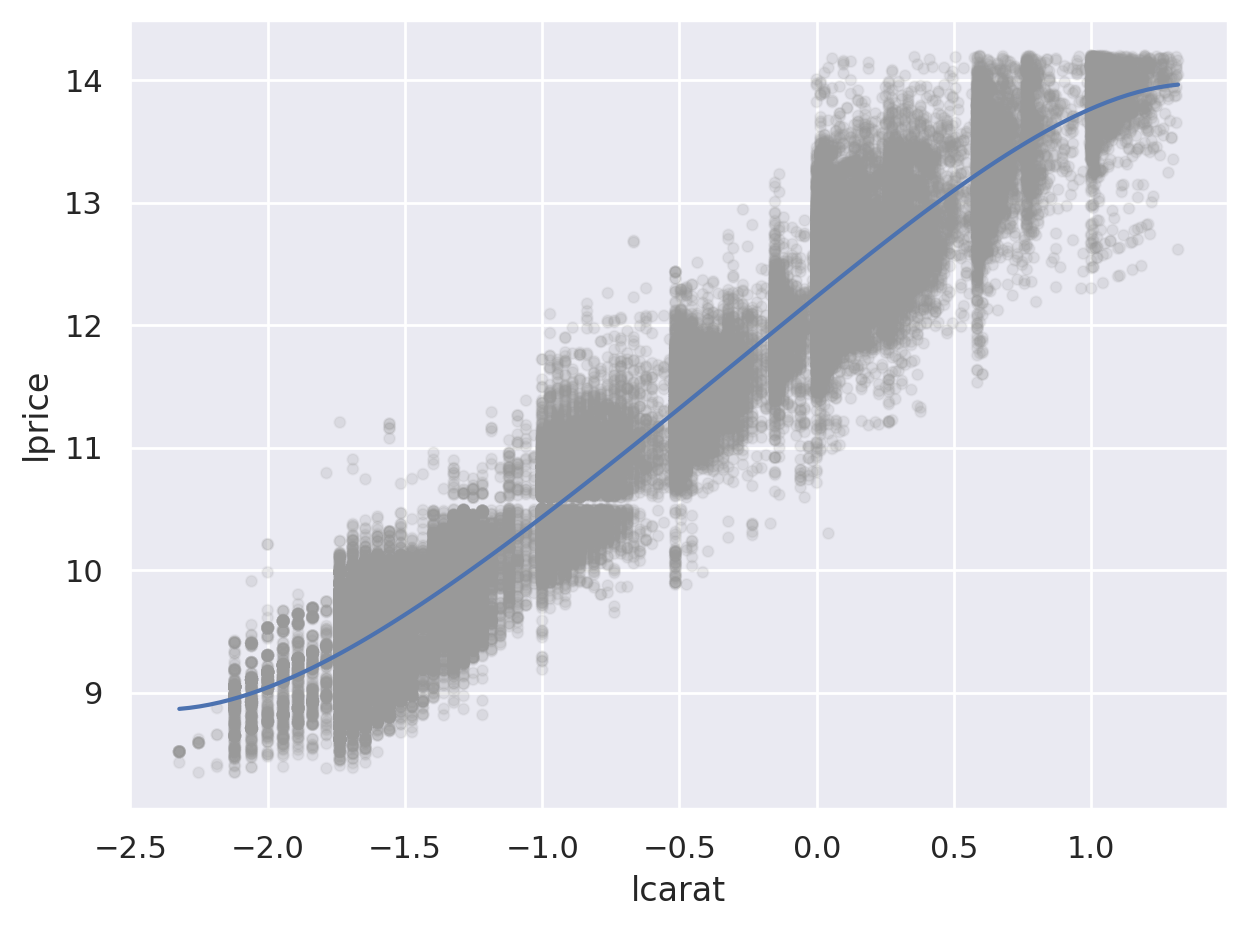

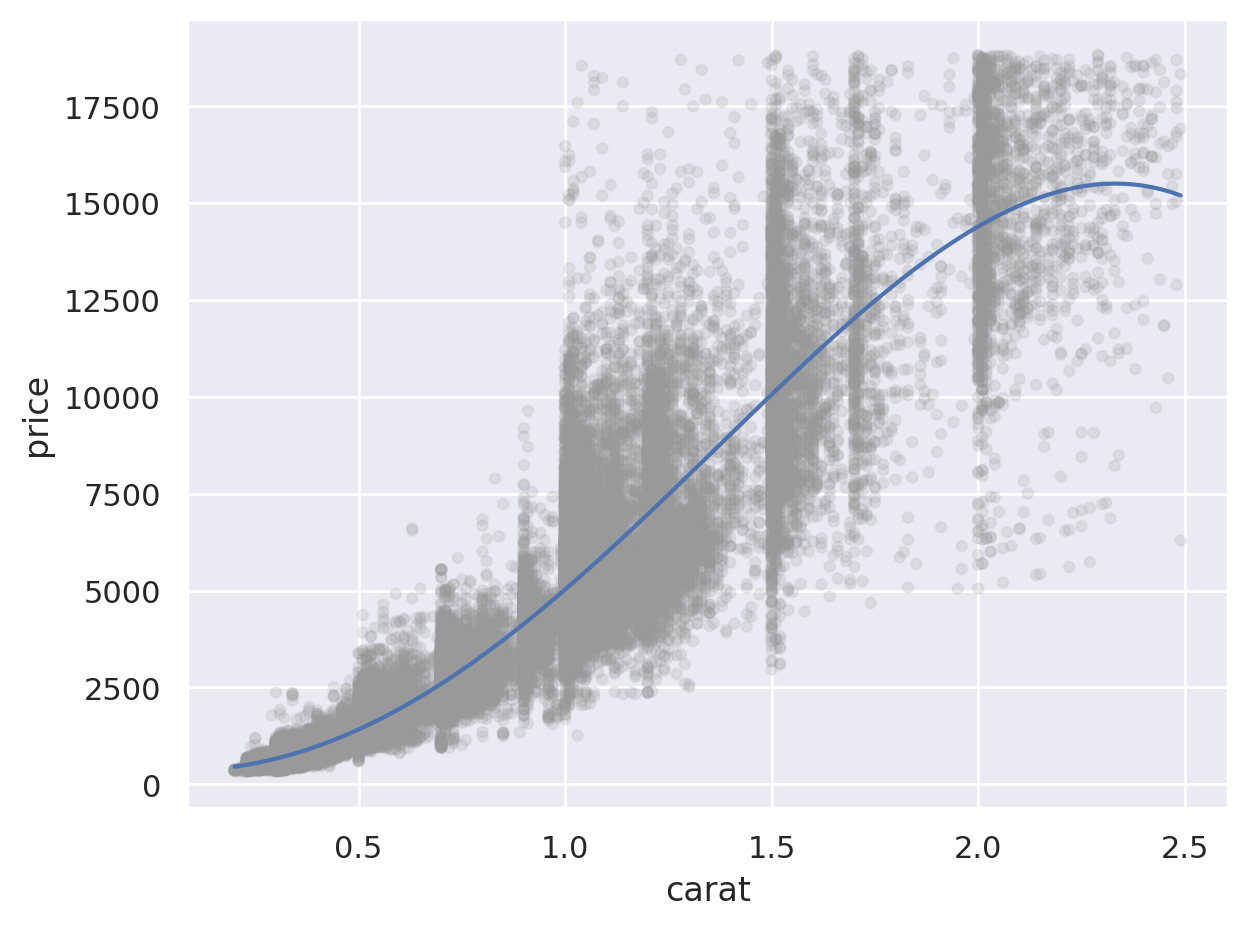

In [ ]:
log_plot = (
    so.Plot(diamonds2, x="lcarat", y="lprice")
    .add(so.Dots(color=".6", alpha=0.1))
    .add(so.Line(), so.PolyFit(5))
).show()

plot = (
    so.Plot(diamonds2, x="carat", y="price")
    .add(so.Dots(color=".6", alpha=0.1))
    .add(so.Line(), so.PolyFit(5))
).show()

# lcarat 변수 1개 OLS

In [ ]:
# 캐럿으로 가격을 예측하는 선형모형
import statsmodels.formula.api as smf

mod_diamonds = smf.ols("lprice ~ lcarat", data=diamonds2).fit()

In [ ]:
# Parmeters
mod_diamonds.params

Intercept   12.19
lcarat       1.68
dtype: float64

## grid 값 만들고, 예측 진행하기 (연속형 변수)

In [ ]:
# Data range from the carat variable
grid = pd.DataFrame({"carat": []})
grid["carat"]= np.linspace(diamonds2.carat.min(), diamonds2.carat.max(), 20)
grid = grid.assign(
    lcarat=lambda x: np.log2(x.carat),  # 모형의 변수와 동일하게 log 변환
    lprice=lambda x: mod_diamonds.predict(x.lcarat),  # prediction
    price=lambda x: 2**x.lprice  # 원래 단위로 되돌리기
)

In [ ]:
grid

,carat,lcarat,lprice,price
0,0.20,-2.32,8.29,312.79
1,0.32,-1.64,9.43,691.47
2,0.44,-1.18,10.21,1182.86
...,...,...,...,...
17,2.25,1.17,14.16,18318.33
18,2.37,1.24,14.29,19999.52
19,2.49,1.32,14.41,21740.08


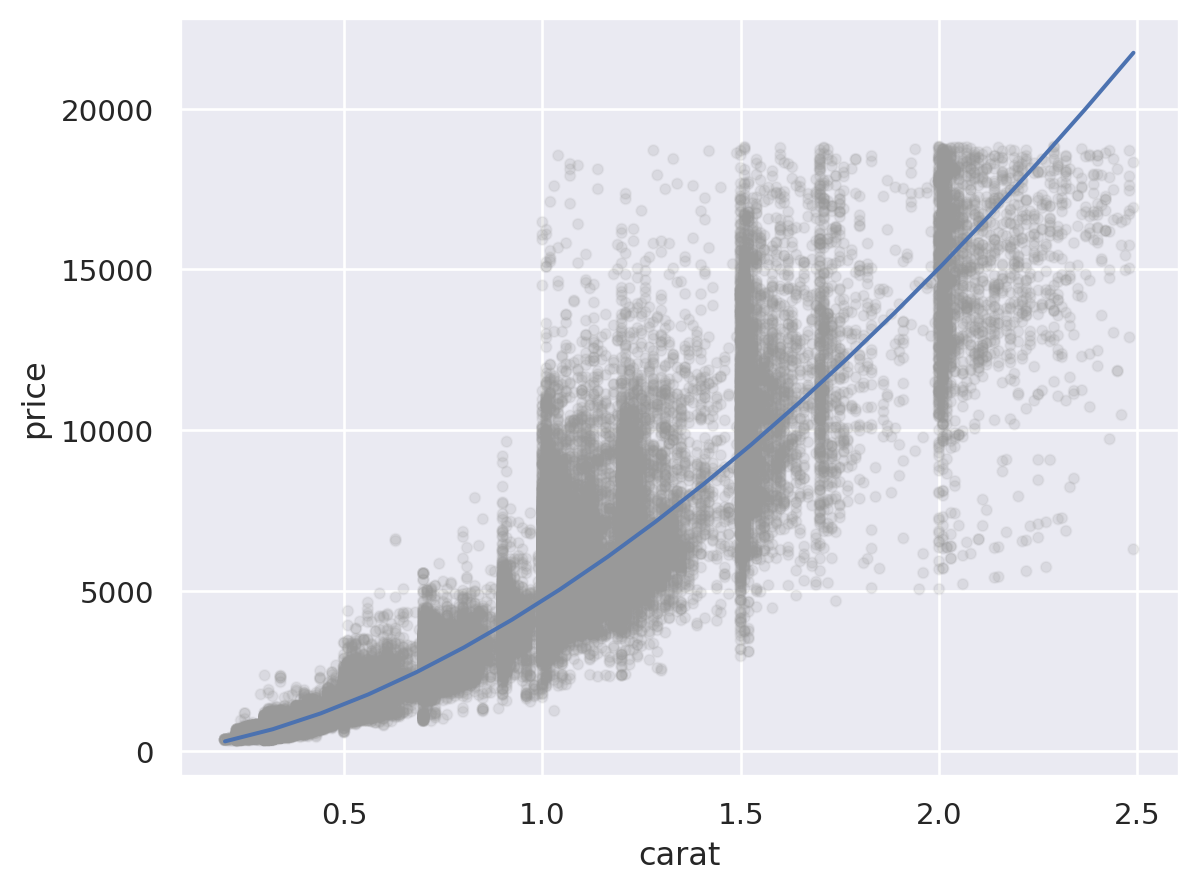

In [ ]:
(
    so.Plot(grid, x="carat", y="price")
    .add(so.Line())
    .add(so.Dots(color=".6", alpha=0.1), x=diamonds2.carat, y=diamonds2.price)
)

# 캐럿과 가격은 비선형적인 관계에 있으며, 이를 log-transform하여 선형적인 관계로 만들어줌
# 또한, variability는 캐럿이 증가함에 따라 비례해서 커지는 양상을 보임; 이 또한 log-transform을 통해 해결되었음

## residuals 분석

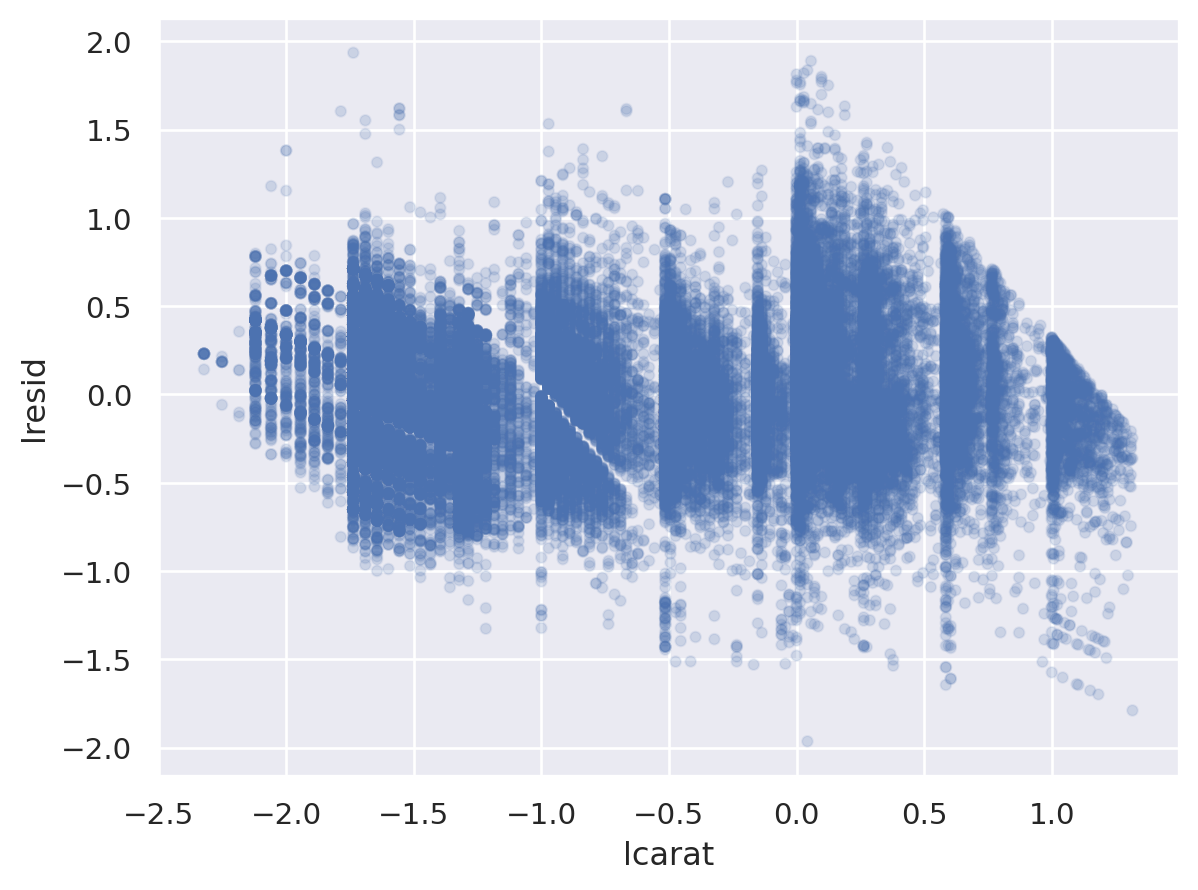

In [ ]:
diamonds2["lresid"] = mod_diamonds.resid

(
    so.Plot(diamonds2, x='lcarat', y='lresid')
    .add(so.Dots(alpha=.1))
)

# y축은 log2 scale로 변환된 것이므로, 원래 단위로 이해하면,
# residual +1은 캐럿으로 예측되는 가격(residual = 0)보다 가격이 2배 비싸다는 것을 의미
# residual -1은 캐럿으로 예측되는 가격(residual = 0)보다 가격이 1/2배 낮다는 것을 의미

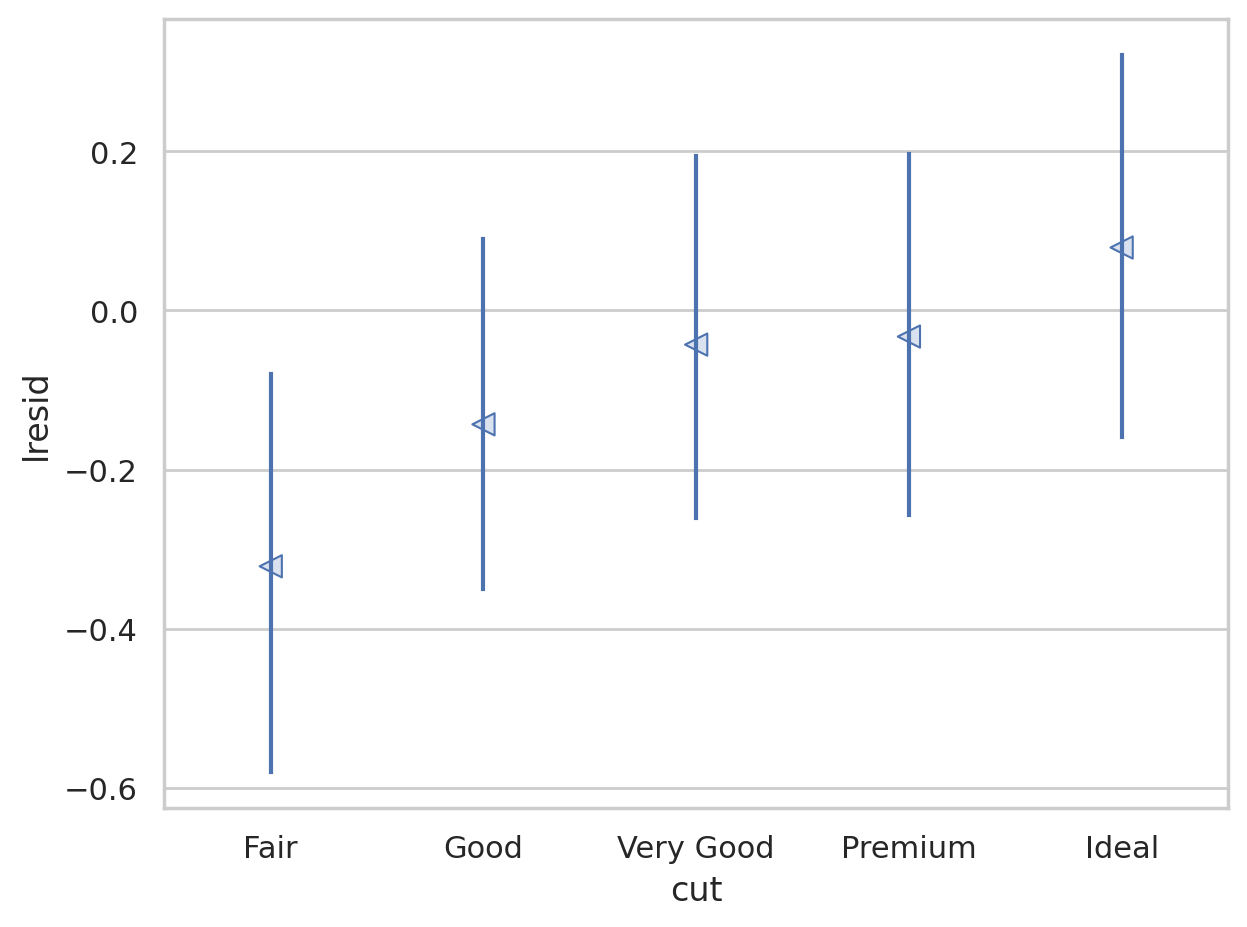

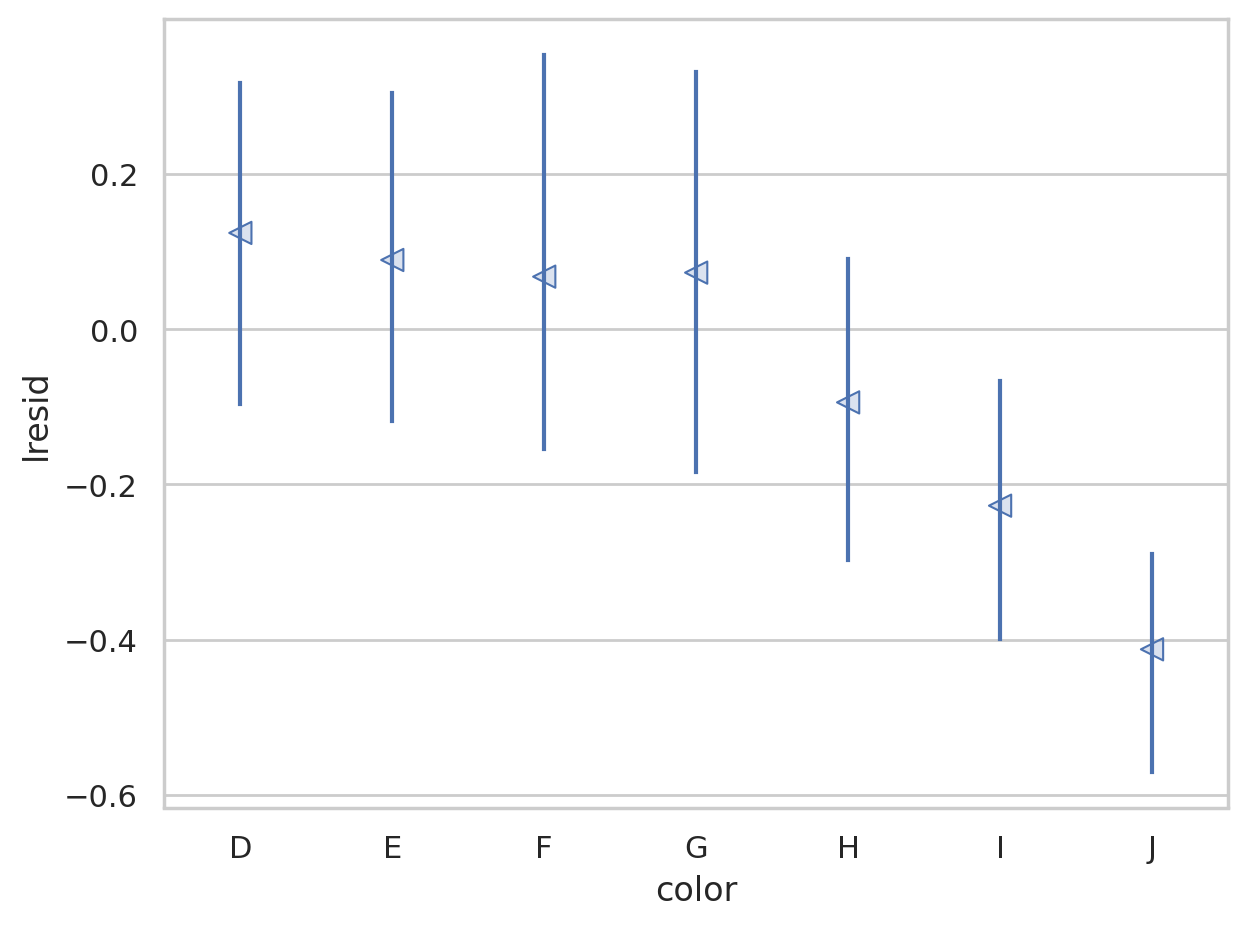

In [ ]:
# 이는 캐럿의 영향을 고려한 후에, 다이아몬드의 퀄리티 각각이 가격에 (상대적으로) 얼마나 영향을 주는지를 가늠할 수 있음
cut = rangeplot(diamonds2, x="cut", y="lresid").show()
color = rangeplot(diamonds2, x="color", y="lresid").show()
clarity = rangeplot(diamonds2, x="clarity", y="lresid").show

# lcarat, cut, color, clarity 변수 4개 OLS

## 이 모형에 의한 cut에 따른 예측값을 구하기 위해, cut을 제외한 다른 값을 고정한 grid 구하기

In [ ]:
mod_full = smf.ols('lprice ~ lcarat + cut + color + clarity', data=diamonds2).fit()

In [ ]:
# 연속 변수는 보통 평균이나 중앙값
# 카테고리 벼수는 보통 최빈값 사용

grid = pd.DataFrame({"cut": ["Fair", "Good", "Very Good", "Premium", "Ideal"]})
grid["color"] = diamonds2.color.mode()[0]  # mode: 최빈값
grid["clarity"] = diamonds2.clarity.mode()[0]
grid["lcarat"] = diamonds2.lcarat.median()

In [ ]:
grid

,cut,color,clarity,lcarat
0,Fair,G,SI1,-0.51
1,Good,G,SI1,-0.51
2,Very Good,G,SI1,-0.51
3,Premium,G,SI1,-0.51
4,Ideal,G,SI1,-0.51


In [ ]:
grid["lpred"] = mod_full.predict(grid)
grid["pred"] = 2**grid.lpred  # 원래 단위인 price로 되돌리기
grid

,cut,color,clarity,lcarat,lpred,pred
0,Fair,G,SI1,-0.51,10.99,2035.36
1,Good,G,SI1,-0.51,11.10,2202.21
2,Very Good,G,SI1,-0.51,11.16,2285.37
3,Premium,G,SI1,-0.51,11.19,2337.24
4,Ideal,G,SI1,-0.51,11.22,2388.52


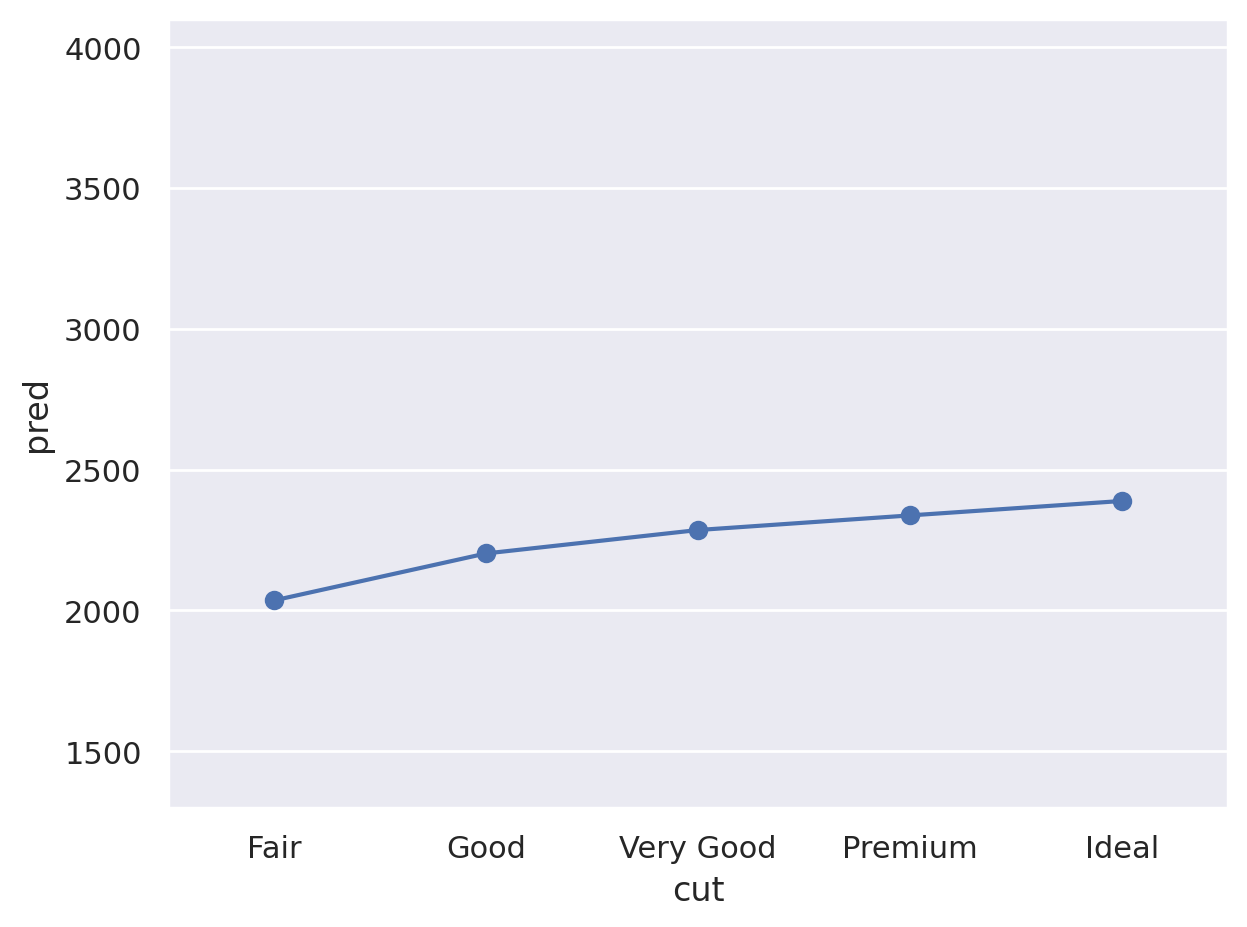

In [ ]:
(
    so.Plot(grid, x='cut', y='pred')
    .add(so.Line(marker="o"))
    .limit(y=(1300, 4100))  # 아래 플랏과 비교하기 위해 y축 범위를 고정
).show()

## residuals 분석

In [ ]:
diamonds2["lresid_full"] = mod_full.resid

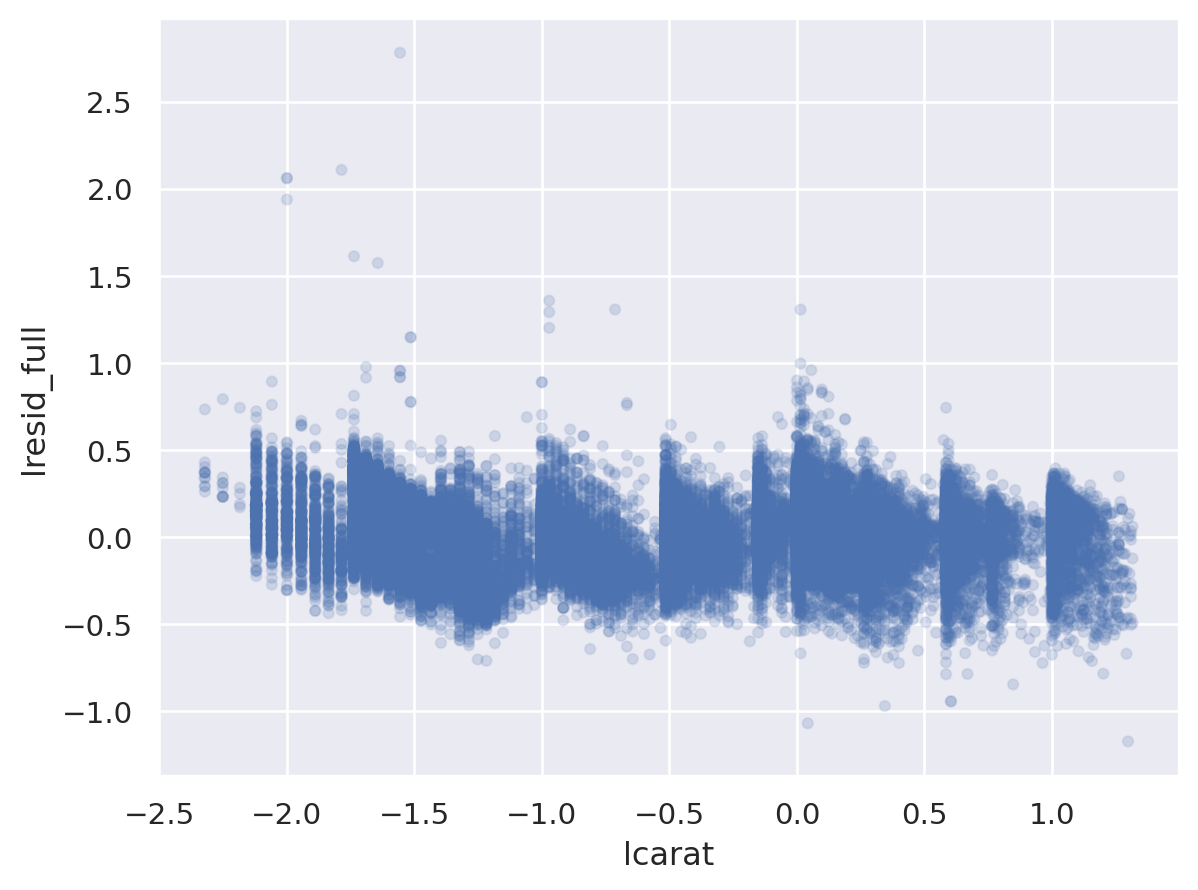

In [ ]:
(
    so.Plot(diamonds2, x='lcarat', y='lresid_full')
    .add(so.Dots(alpha=.1))
)

## 이상치 확인

In [ ]:
from numpy import abs

diamonds2.query("@abs(lresid_full) > 1").assign(
    pred_full=lambda x: 2 ** mod_full.predict(x[["lcarat", "cut", "color", "clarity"]]),
    resid_full=lambda x: x.price - x.pred_full,
).sort_values("resid_full")

,carat,cut,color,clarity,depth,table,price,x,y,z,lprice,lcarat,lresid,lresid_full,pred_full,resid_full
22440,2.46,Premium,E,SI2,59.70,59.00,10470,8.82,8.76,5.25,13.35,1.30,-1.02,-1.17,23630.26,-13160.26
41918,1.03,Fair,E,I1,78.20,54.00,1262,5.72,5.59,4.42,10.30,0.04,-1.96,-1.07,2650.65,-1388.65
38153,0.25,Fair,F,SI2,54.40,64.00,1013,4.30,4.23,2.32,9.98,-2.00,1.15,1.94,264.51,748.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5325,0.61,Good,F,SI2,62.50,65.00,3807,5.36,5.29,3.33,11.89,-0.71,0.90,1.31,1539.74,2267.26
8203,0.51,Fair,F,VVS2,60.70,66.00,4368,5.21,5.11,3.13,12.09,-0.97,1.53,1.36,1706.07,2661.93
21935,1.01,Fair,D,SI2,64.60,58.00,10011,6.25,6.20,4.02,13.29,0.01,1.07,1.30,4052.40,5958.60


# 3가지 모델 비교하기

In [ ]:
diamonds2 = diamonds.query("carat < 2.5").assign(
    lprice=lambda x: np.log2(x.price),
    lcarat=lambda x: np.log2(x.carat)
)

# Nested models
diamonds2_mod1 = smf.ols("lprice ~ lcarat", data=diamonds2).fit()
diamonds2_mod2 = smf.ols("lprice ~ lcarat + clarity", data=diamonds2).fit()
diamonds2_mod3 = smf.ols("lprice ~ lcarat + cut + color + clarity", data=diamonds2).fit()

## melt 함수 사용해서 long foramt 만들고, 이를 시각화

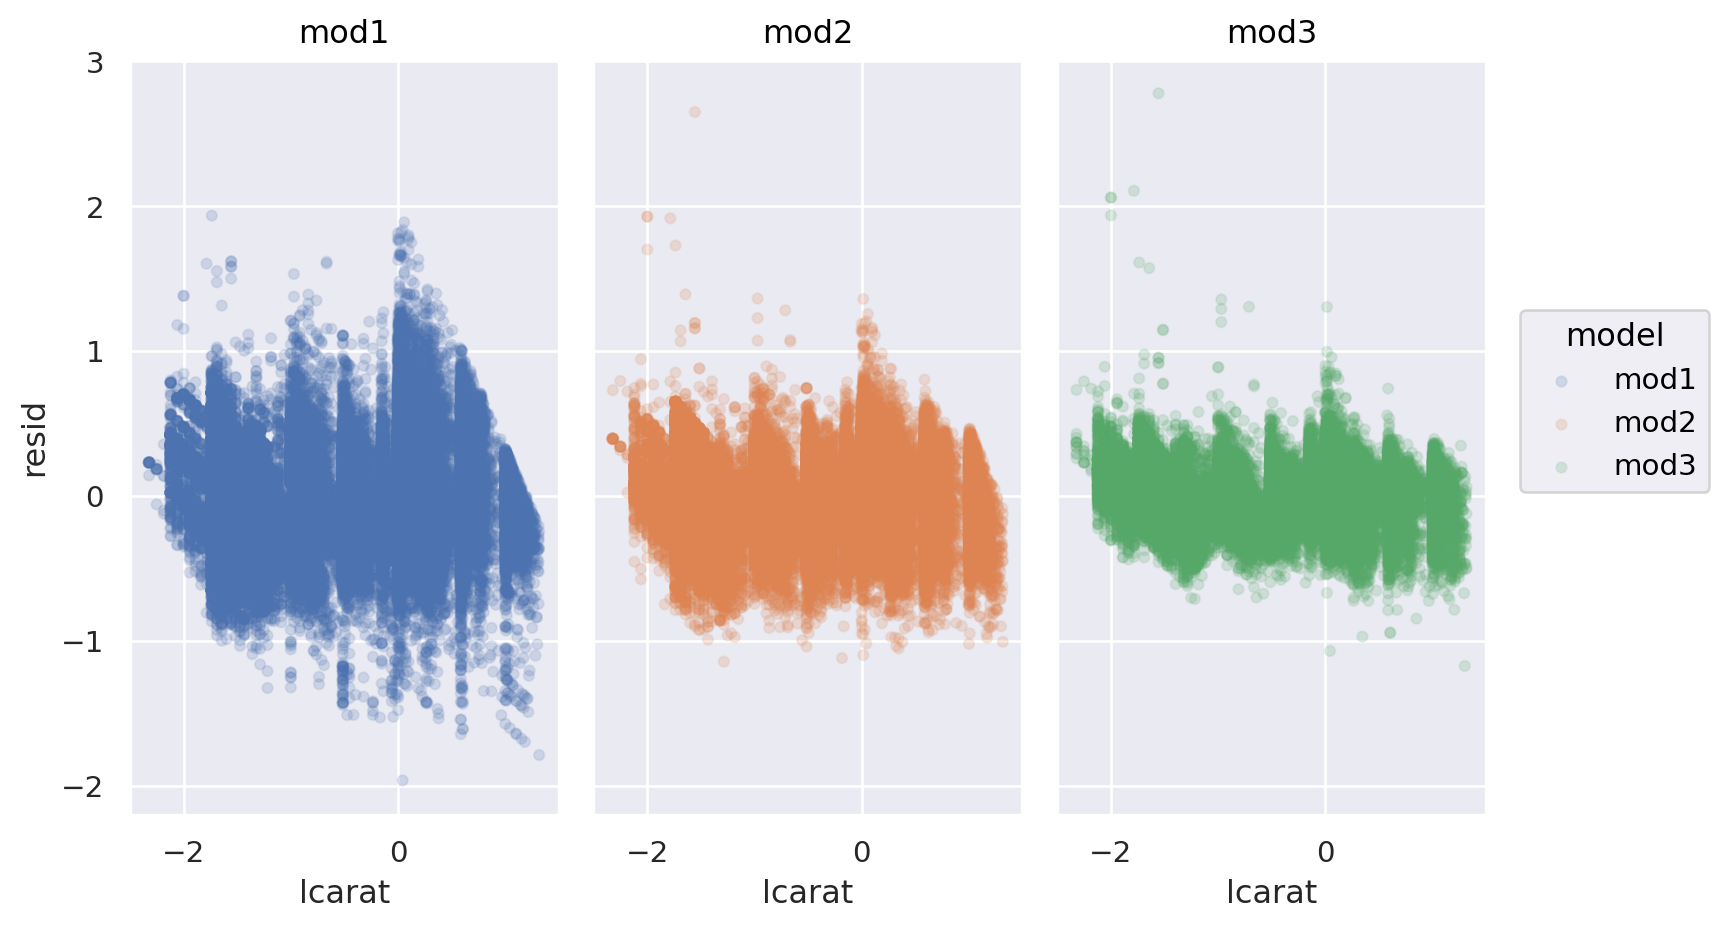

In [ ]:
diamonds2_mods = diamonds2.assign(
    mod1=diamonds2_mod1.resid,
    mod2=diamonds2_mod2.resid,
    mod3=diamonds2_mod3.resid,
)

diamonds2_mods = diamonds2_mods.melt(
    id_vars=["lcarat", "lprice"],
    value_vars=["mod1", "mod2", "mod3"],
    var_name="model",
    value_name="resid",
)

(
    so.Plot(diamonds2_mods, x='lcarat', y='resid', color='model')
    .add(so.Dots(alpha=.1))
    .facet("model")
    .layout(size=(8, 5))
)

## rmse와 R2_square 출력하기

In [ ]:
from statsmodels.tools.eval_measures import rmse, meanabs

mods = [diamonds2_mod1, diamonds2_mod2, diamonds2_mod3]
y = diamonds2.price
print("The prediction accuracy of the models (original unit except R-squared):\n")

for i, mod in enumerate(mods):
    y_hat = 2**mod.fittedvalues
    R2 = np.var(y_hat) / np.var(y)
    R2_log = mod.rsquared

    print(
        f"Model {i+1} >> R-squared(log): {R2_log:.2f}, R_squared {R2:.2f}, "
        f"RMSE: {rmse(y, y_hat):.2f}, MAE:{meanabs(y, y_hat):.2f}"
    )

The prediction accuracy of the models (original unit except R-squared):

Model 1 >> R-squared(log): 0.93, R_squared 0.88, RMSE: 1507.04, MAE:817.34
Model 2 >> R-squared(log): 0.97, R_squared 0.98, RMSE: 1164.81, MAE:623.65
Model 3 >> R-squared(log): 0.98, R_squared 0.95, RMSE: 732.70, MAE:390.61


# 상호작용이 있는 모델과 없는 모델 비교하기

In [ ]:
diamonds2_mod2 = smf.ols("lprice ~ lcarat + clarity", data=diamonds2).fit()
diamonds2_mod2_interact = smf.ols("lprice ~ lcarat * clarity", data=diamonds2).fit()

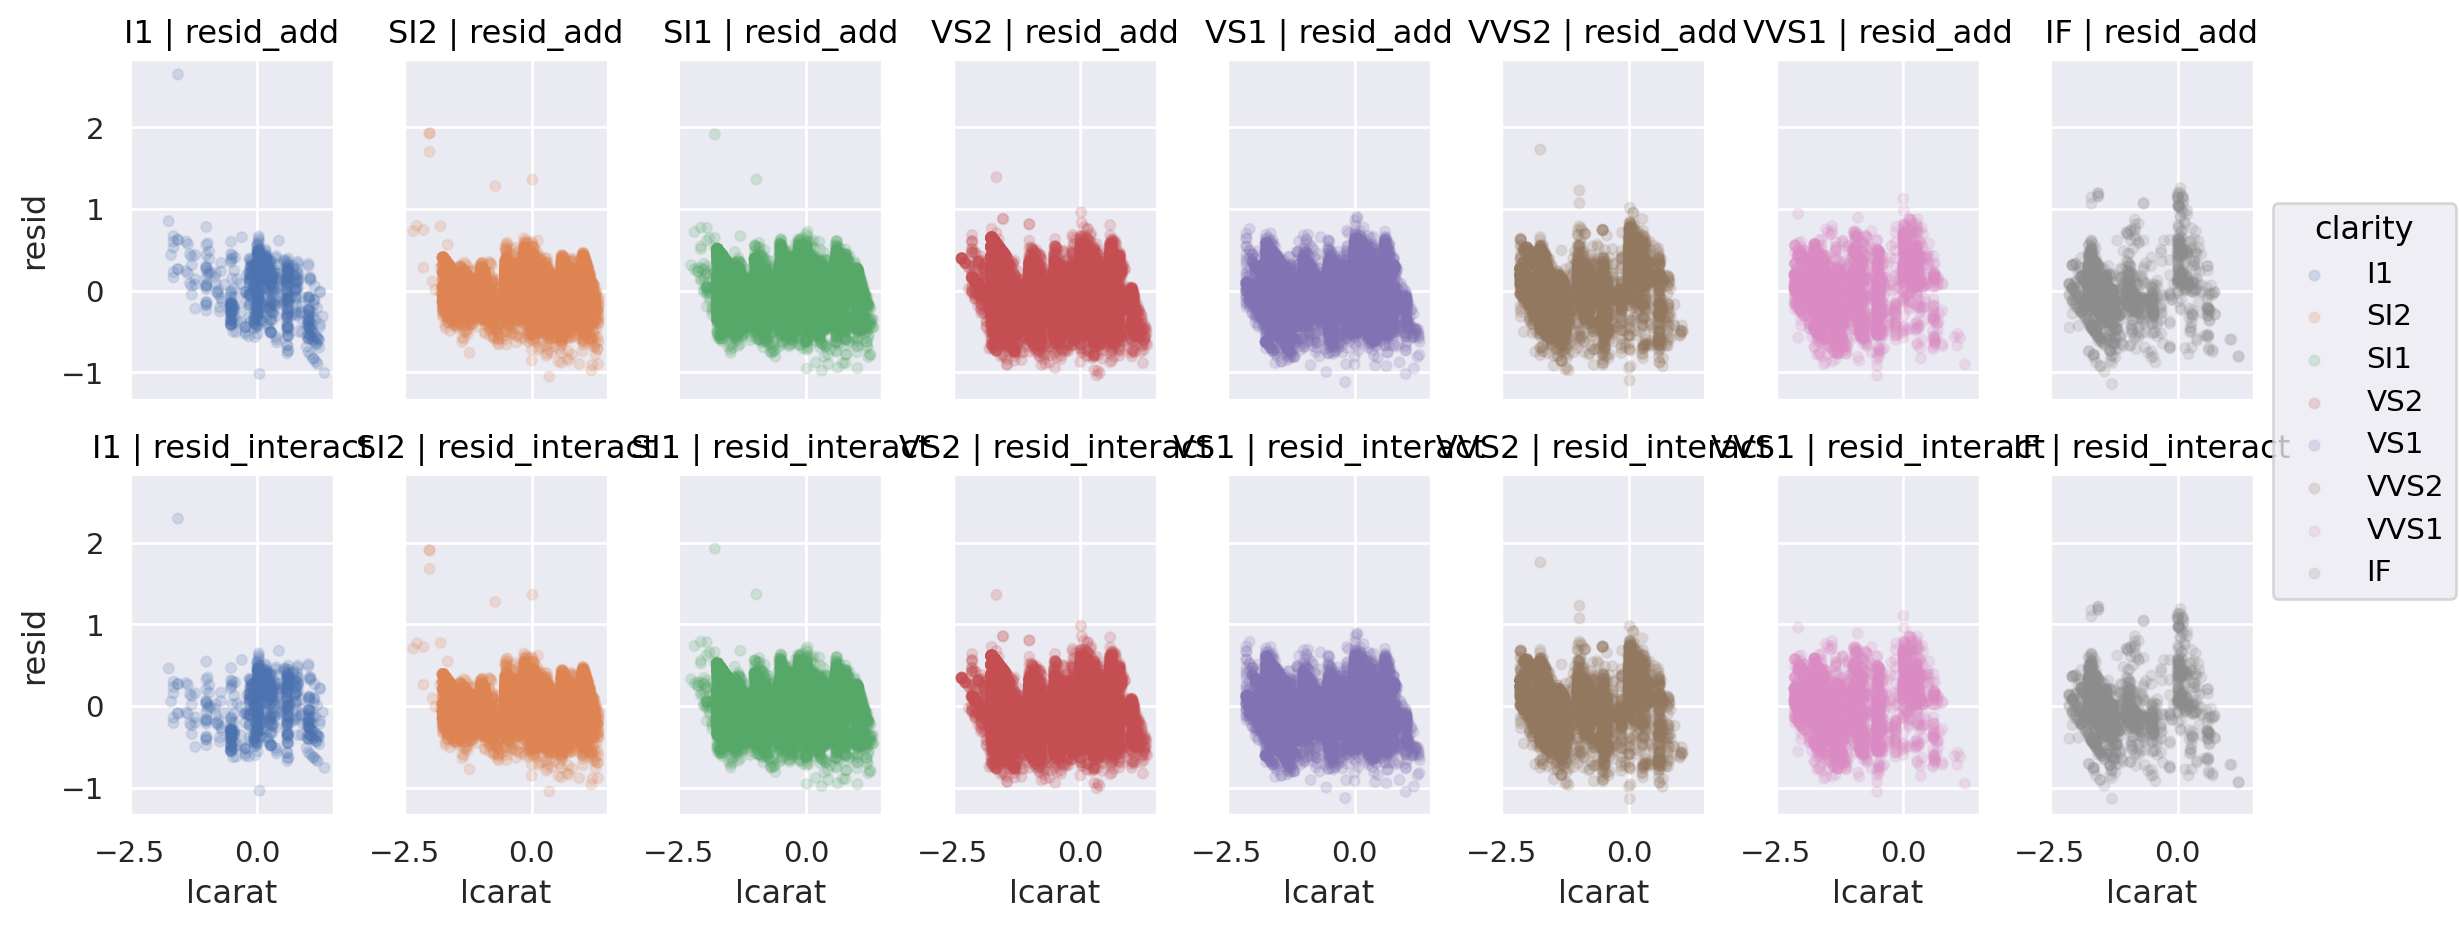

In [ ]:
diamonds2_mods = diamonds2.assign(
    resid_add=diamonds2_mod2.resid,
    resid_interact=diamonds2_mod2_interact.resid,
)

diamonds2_mods = diamonds2_mods.melt(
    id_vars=["lcarat", "lprice", "clarity"],
    value_vars=["resid_add", "resid_interact"],
    var_name="model",
    value_name="resid",
)

(
    so.Plot(diamonds2_mods, x="lcarat", y="resid", color="clarity")
    .add(so.Dots(alpha=0.1))
    .layout(size=(12, 5))
    .facet("clarity", "model")
)